In [1]:
# This code can be downloaded as a Python script and run as:
# python full_vs_EM_any_dataset.py random_state dataset_name test_proportion val_proportion M_method M_alpha M_beta
#     test_proportion: The test proportion is from all the available true labels
#     val_proportion: The validation proportion is from the remaining training proportion with the true labels

def is_interactive():
    import __main__ as main
    return not hasattr(main, '__file__')

import sys
import numpy
import matplotlib

dataset_name = 'webs'
experiment_name = 'Example_19'
M_method_list = ('learned', ) # Weak labels in training
train_val_test_proportions = numpy.array([0.5, 0.2, 0.3]) # Train, validation and test proportions

if is_interactive():
    # This is for the demo in the Jupyter notebook
    %matplotlib inline
    sys.path.append('../')
    # Define all the variables for this experiment
    random_state = 0
    weak_prop = 0.05 # proportion of weak data to use [the rest is dropped]
    data_folder = '../data/'
    # In this dataset the best l2 parameter is 0.0
    #l2_list = numpy.array([0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1])
    max_epochs = 10  # Upper limit on the number of epochs
    l2_list = numpy.array([0.0, 1e-6, 1e0])
else:
    # This is for the final run as a script
    random_state = int(sys.argv[1])
    weak_prop = float(sys.argv[2])
    matplotlib.use('Agg')
    data_folder = './data/'
    max_epochs = 100  # Upper limit on the number of epochs
    l2_list = numpy.array([0.0, 1e-7, 1e-5, 1e-3, 1e-1, 1e0, 1e1])
    
import keras
from keras import backend as K

import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from wlc.WLweakener import computeM, generateWeak, weak_to_index, binarizeWeakLabels, estimate_M
from experiments.visualizations import plot_history
from experiments.visualizations import plot_multilabel_scatter
from sklearn.model_selection import train_test_split

cmap = plt.cm.get_cmap('tab20')

Using TensorFlow backend.
/media/disk2/git/uob/RecyclingLabels/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/media/disk2/git/uob/RecyclingLabels/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/media/disk2/git/uob/RecyclingLabels/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

# 1. Load dataset
## 1.a. Obtain dataset with true labels

In [2]:
from experiments.data import load_webs

only_weak, weak_and_true, only_true, classes = load_webs(tfidf=True, standardize=True,
                                                categories=['blog', 'inmo', 'parking', 'b2c', 'no_b2c', 'Other'],
                                                #categories=['parking', 'b2c', 'no_b2c', 'Other'],

                                                random_state=random_state,
                                                folder=data_folder)

X_w, Z_w, z_w, Y_w, y_w = only_weak

# Discard part of the training weak data
if weak_prop != 1.0:
    X_w, _, Z_w, _, z_w, _= train_test_split(X_w, Z_w, z_w, test_size=1-weak_prop, random_state=random_state)

X_wt, Z_wt, z_wt, Y_wt, y_wt = weak_and_true

n_classes = Y_wt.shape[1]
n_features = X_w.shape[1]
n_samples = X_w.shape[0] + X_wt.shape[0]

print('Number of samples = {}'.format(n_samples))
print('Number of features = {}'.format(n_features))
print('Number of classes = {}'.format(n_classes))
print('Class names = {}'.format(classes))
labels, counts = numpy.unique(y_wt, return_counts=True)
print('Labels = {}'.format(labels))
print('Counts = {}'.format(counts))
print('Proportions = {}'.format(counts/counts.sum()))

../experiments/data.py:162: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  Y_val = dfY[categories].as_matrix()
../experiments/data.py:176: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  Z_val = dfZ.iloc[indices_val][categories].as_matrix().astype(int)
../experiments/data.py:181: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  Z_train = dfZ[mask_train][categories].as_matrix().astype(int)


Number of samples = 4544
Number of features = 2099
Number of classes = 6
Class names = ['blog', 'inmo', 'parking', 'b2c', 'no_b2c', 'Other']
Labels = [0 1 2 3 4 5]
Counts = [ 23  39 153 159 700 175]
Proportions = [0.01841473 0.03122498 0.122498   0.12730184 0.56044836 0.14011209]


## 1.b. Divide into training, validation and test

- Validation and test will always have only true labels, while the training may have weak labels as well

- $S_{train} = \{S_{wt-train}, S_{w-train}\} = [\{(x_i, b_i, y_i), i = 1,...,n\} X x Z x C, \{(x_i, b_i), i = 1,...,n\} \in X x Z\}]$
- $S_{val} = \{(x_i, y_i), i = 1,...,n\} \in X x C$
- $S_{test} = \{(x_i, y_i), i = 1,...,n\} \in X x C$

In [3]:
#train_val_test_proportions = numpy.array([0.5, 0.2, 0.3])
print('Original proportions for the 3 partitions (train, validation and test)')
print(train_val_test_proportions)
# Ensure that all proportions sum to 1
train_val_test_proportions /= train_val_test_proportions.sum()
print('Proportions where to split')
train_val_test_proportions = numpy.cumsum(train_val_test_proportions)
print(train_val_test_proportions)
print('Indices where to split (from a total of {} samples)'.format(X_wt.shape[0]))
indices = (train_val_test_proportions*X_wt.shape[0]).astype(int)[:-1]
print(indices)

# # Divide into training, validation and test
X_wt_train, X_wt_val, X_wt_test = numpy.array_split(X_wt, indices)
Z_wt_train, Z_wt_val, Z_wt_test = numpy.array_split(Z_wt, indices)
z_wt_train, z_wt_val, z_wt_test = numpy.array_split(z_wt, indices)
Y_wt_train, Y_wt_val, Y_wt_test = numpy.array_split(Y_wt, indices)
y_wt_train, y_wt_val, y_wt_test = numpy.array_split(y_wt, indices)

X_w_train = X_w
Z_w_train = Z_w
z_w_train = z_w

print('Final sizes')
print('Training samples without true labels = {}'.format(X_w_train.shape[0]))
print('Training samples with true labels = {}'.format(X_wt_train.shape[0]))
print('Validation samples with true labels = {}'.format(X_wt_val.shape[0]))
print('Test samples with true labels = {}'.format(X_wt_test.shape[0]))

Original proportions for the 3 partitions (train, validation and test)
[0.5 0.2 0.3]
Proportions where to split
[0.5 0.7 1. ]
Indices where to split (from a total of 1249 samples)
[624 874]
Final sizes
Training samples without true labels = 3295
Training samples with true labels = 624
Validation samples with true labels = 250
Test samples with true labels = 375


## 1.c. Generate weakening processes

- This will generate weak labels given the specified mixing process.
- It will also show 3 plots with the true labels, weak labels and the corresponding rows of the mixing matrix M.
- In all the mixing processes we remove the unlabeled option as this can be seen as the all labels (if we assume that every samples belongs to one class)

## 1.d. Divide training into weak portions

- Currently every weak partition is of the same size
- We will assume that a proportion of each weak set has been annotated with the true labels

In [4]:
X_wt_train_list = (X_wt_train,)
Z_wt_train_list = (Z_wt_train,)
z_wt_train_list = (z_wt_train,)
Y_wt_train_list = (Y_wt_train,)
y_wt_train_list = (y_wt_train,)

X_w_train_list = (X_w_train,)
Z_w_train_list = (Z_w_train,)
z_w_train_list = (z_w_train,)

In [5]:
M_method_list = ('learned', )
    
M_list = (estimate_M(numpy.concatenate((Z_wt_train, Z_wt_val, Z_wt_test)),
                     numpy.concatenate((Y_wt_train, Y_wt_val, Y_wt_test)),
                     classes, reg='Partial', Z_reg=Z_w_train, alpha=1.0),)

print(M_list)

(matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.32352941, 0.12      , 0.40853659, 0.13529412, 0.23347398,
         0.55376344],
        [0.05882353, 0.02      , 0.03658537, 0.01176471, 0.04500703,
         0.0483871 ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.14705882, 0.08      , 0.0304878 , 0.44705882, 0.02531646,
         0.03763441],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.26470588, 0.6       , 0.2804878 , 0.35882353, 0.68495077,
         0.3172043 ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.02941176, 0.02      , 0.13414634, 0.00588235, 0.00281294,
         0.01075269],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ]

/media/disk2/git/uob/RecyclingLabels/venv/lib/python3.6/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


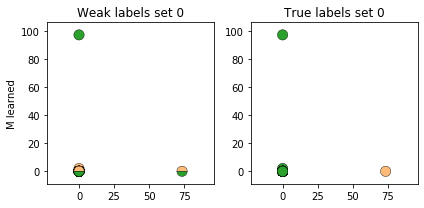

In [6]:
from experiments.visualizations import plot_multilabel_scatter

fig = plt.figure(figsize=(6, len(z_wt_train_list)*3))
j = 1
for i in range(len(Z_wt_train_list)):
    ax = fig.add_subplot(len(Z_wt_train_list), 2, j)
    _ = plot_multilabel_scatter(X_wt_train_list[i][:100, ], Z_wt_train_list[i][:100], fig=fig,
                                ax=ax, title='Weak labels set {}'.format(i), cmap=cmap)
    ax.set_ylabel('M {}'.format(M_method_list[i]))
    ax = fig.add_subplot(len(Z_wt_train_list), 2, j+1)
    _ = plot_multilabel_scatter(X_wt_train_list[i][:100], Y_wt_train_list[i][:100], fig=fig,
                                ax=ax, title='True labels set {}'.format(i), cmap=cmap)
    j += 2
fig.tight_layout()

# Define a common model

# TODO check the validation data! it is currently ussing the true labels, should we use the weak labels?

In [7]:
from keras.callbacks import EarlyStopping, Callback
from keras import regularizers

def log_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, K.epsilon(), 1.0-K.epsilon())
    out = -y_true*K.log(y_pred)
    return K.mean(out, axis=-1)

#max_epochs = 1000

# Callback to show performance per epoch in the same line
class EpochCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        print('\rEpoch {}, val_loss = {:.2e}, val_acc = {:.2f}'.format(epoch, logs['val_loss'], logs['val_acc']), end=' ')

# Callback for early stopping
epoch_callback = EpochCallback()
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=int(max_epochs/20), 
                               verbose=2, mode='auto', baseline=None,
                               restore_best_weights=True)

def make_model(loss, l2=0.0):
    # Careful that it is ussing global variables for the input and output shapes
    numpy.random.seed(random_state)
    model = keras.models.Sequential() 
    model.add(keras.layers.Dense(n_classes, input_dim=n_features,
                                 kernel_regularizer=regularizers.l2(l2),
                                 activation='softmax'))
    model.compile(optimizer='adam', loss=loss, metrics=['ce', 'mse', 'acc'])
    return model

# Keyword arguments for the fit function
fit_kwargs = dict(validation_data=(X_wt_val, Y_wt_val), epochs=max_epochs, verbose=0,
                  callbacks=[early_stopping, epoch_callback], shuffle=True)

# Save the final model for each method
final_models = {}

# Fully supervised (upperbound)

Train with all true labels

W0820 13:21:36.591735 140020777699136 deprecation_wrapper.py:119] From /media/disk2/git/uob/RecyclingLabels/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0820 13:21:36.610197 140020777699136 deprecation_wrapper.py:119] From /media/disk2/git/uob/RecyclingLabels/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0820 13:21:36.614701 140020777699136 deprecation_wrapper.py:119] From /media/disk2/git/uob/RecyclingLabels/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0820 13:21:36.633792 140020777699136 deprecation_wrapper.py:119] From /media/disk2/git/uob/RecyclingLabels/venv/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimiz

Training with l2 = 0.00e+00


W0820 13:21:36.950426 140020777699136 deprecation.py:323] From /media/disk2/git/uob/RecyclingLabels/venv/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0820 13:21:36.991599 140020777699136 deprecation_wrapper.py:119] From /media/disk2/git/uob/RecyclingLabels/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 4, val_loss = 2.62e-01, val_acc = 0.54 Restoring model weights from the end of the best epoch
Epoch 5, val_loss = 2.64e-01, val_acc = 0.54 Epoch 00006: early stopping


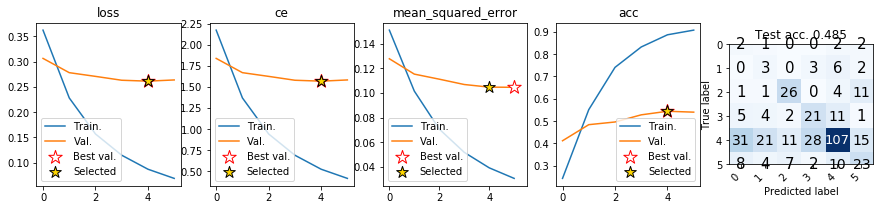

<Figure size 360x288 with 0 Axes>

Training with l2 = 1.00e-06
Epoch 4, val_loss = 2.61e-01, val_acc = 0.54 Restoring model weights from the end of the best epoch
Epoch 5, val_loss = 2.64e-01, val_acc = 0.54 Epoch 00006: early stopping


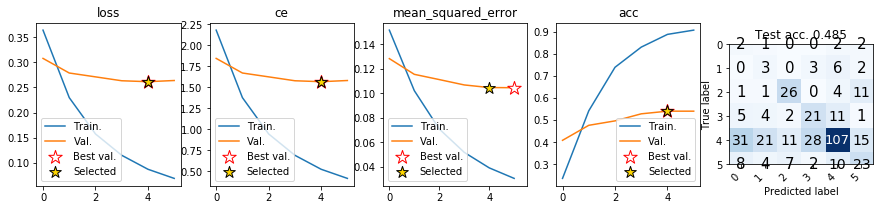

<Figure size 360x288 with 0 Axes>

Training with l2 = 1.00e+00
Epoch 9, val_loss = 2.77e-01, val_acc = 0.66 

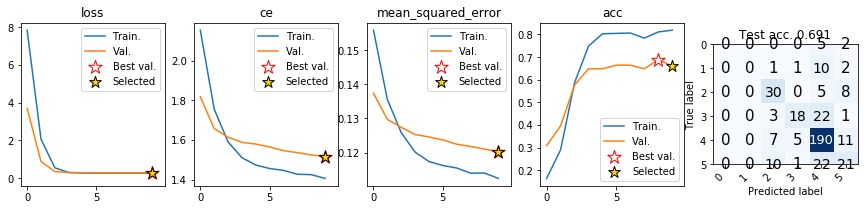

<Figure size 360x288 with 0 Axes>

Best l2 = 1e-06


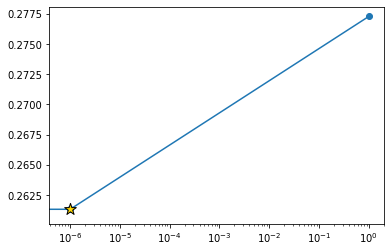

In [8]:
train_method = 'Supervised'

models_list = {}
models_list[train_method] = []
val_losses = numpy.zeros_like(l2_list)
for i, l2 in enumerate(l2_list):
    print('Training with l2 = {:.2e}'.format(l2))
    model = make_model(log_loss, l2=l2)
    history = model.fit(*X_wt_train_list,
                        *Y_wt_train_list,
                        **fit_kwargs)

    plot_history(history, model, X_wt_test, y_wt_test)
    models_list[train_method].append(model)
    best_epoch = numpy.argmin(model.history.history['val_loss'])
    val_losses[i] = model.history.history['val_loss'][best_epoch]
    plt.show()

best_l2 = numpy.argmin(val_losses)
final_models[train_method] = models_list[train_method][best_l2]
l2 = l2_list[best_l2]
print('Best l2 = {}'.format(l2))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogx(l2_list, val_losses, 'o-')
ax.scatter(l2, val_losses[best_l2], color='gold',
           edgecolor='black', marker='*', s=150, zorder=3)

# Our method with EM best estimation M

Train EM with all weak labels

Training with l2 = 0.00e+00
q_0 weak = 0.841
q_0 true = 0.159
Epoch 2, val_loss = 2.45e-01, val_acc = 0.60 Restoring model weights from the end of the best epoch
Epoch 3, val_loss = 2.46e-01, val_acc = 0.59 Epoch 00004: early stopping


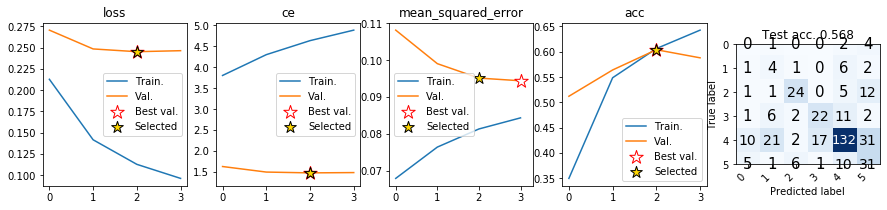

<Figure size 360x288 with 0 Axes>

Training with l2 = 1.00e-06
q_0 weak = 0.841
q_0 true = 0.159
Epoch 2, val_loss = 2.45e-01, val_acc = 0.60 Restoring model weights from the end of the best epoch
Epoch 3, val_loss = 2.46e-01, val_acc = 0.59 Epoch 00004: early stopping


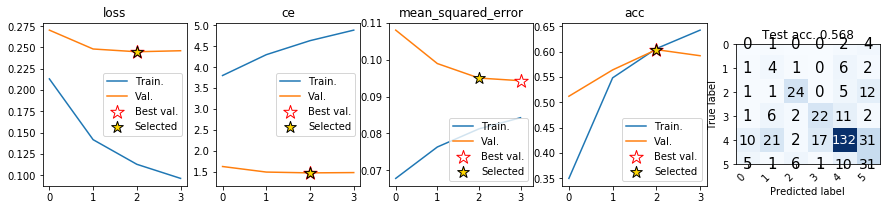

<Figure size 360x288 with 0 Axes>

Training with l2 = 1.00e+00
q_0 weak = 0.841
q_0 true = 0.159
Epoch 9, val_loss = 2.34e-01, val_acc = 0.54 

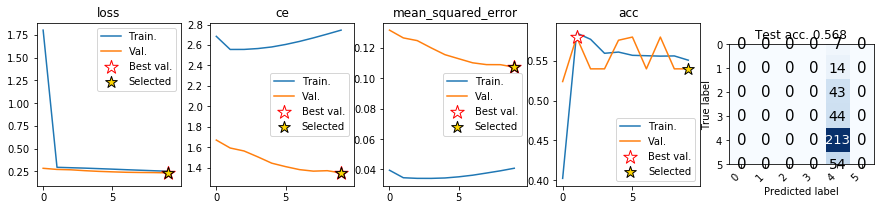

<Figure size 360x288 with 0 Axes>

Best l2 = 1e-06


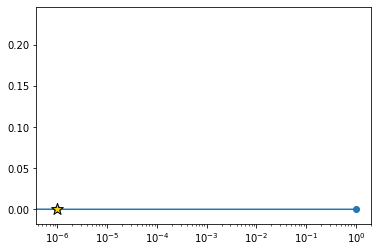

In [9]:
train_method = 'EM best estimation M'

def EM_log_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, K.epsilon(), 1.0-K.epsilon())
    Q = y_true * y_pred
    Z_em_train = Q / K.sum(Q, axis=-1, keepdims=True)
    out = -K.stop_gradient(Z_em_train)*K.log(y_pred)
    return K.mean(out, axis=-1)

models_list[train_method] = []
val_losses = numpy.zeros_like(l2_list)
for i, l2 in enumerate(l2_list):
    print('Training with l2 = {:.2e}'.format(l2))
    model = make_model(EM_log_loss, l2=l2)

    M_true_list = []
    n_samples_train = X_w_train.shape[0] + X_wt_train.shape[0]
    # Add weak samples
    for i, M in enumerate(M_list):
        q = (X_w_train_list[i].shape[0]/n_samples_train)
        M_true_list.append(M * q)
        print('q_{} weak = {:.3f}'.format(i, q))
    # Add true samples
    M_supervised = computeM(n_classes, method='supervised')
    for i, M in enumerate(M_list):
        q = (X_wt_train_list[i].shape[0]/n_samples_train)
        M_true_list.append(M_supervised * q)
        print('q_{} true = {:.3f}'.format(i, q))

    M_true = numpy.concatenate(M_true_list)
    last_index = 0
    Z_train_index_list = []
    V_train_list = []
    # Add weak samples
    for i in range(len(M_method_list)):
        Z_train_index_list.append(last_index + weak_to_index(Z_w_train_list[i], method=M_method_list[i]))
        last_index += len(M_list[i])
        V_train_list.append(M_true[Z_train_index_list[-1]])
    # Add true samples
    for i in range(len(M_method_list)):
        Z_train_index_list.append(last_index + weak_to_index(Y_wt_train_list[i], method='supervised'))
        last_index += n_classes
        V_train_list.append(M_true[Z_train_index_list[-1]])

    history = model.fit(numpy.concatenate((*X_w_train_list, *X_wt_train_list)),
                        numpy.concatenate(V_train_list),
                        **fit_kwargs)

    plot_history(history, model, X_wt_test, y_wt_test)
    models_list[train_method].append(model)
    best_epoch = numpy.argmin(model.history.history['val_loss'])
    val_losses[i] = model.history.history['val_loss'][best_epoch]
    plt.show()
    
best_l2 = numpy.argmin(val_losses)
final_models[train_method] = models_list[train_method][best_l2]
l2 = l2_list[best_l2]
print('Best l2 = {}'.format(l2))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogx(l2_list, val_losses, 'o-')
ax.scatter(l2, val_losses[best_l2], color='gold',
           edgecolor='black', marker='*', s=150, zorder=3)

# Our method with EM and estimated M

/media/disk2/git/uob/RecyclingLabels/venv/lib/python3.6/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


q_0 weak = 0.841
q_0 true = 0.159
Epoch 3, val_loss = 2.44e-01, val_acc = 0.60 Restoring model weights from the end of the best epoch
Epoch 4, val_loss = 2.50e-01, val_acc = 0.60 Epoch 00005: early stopping


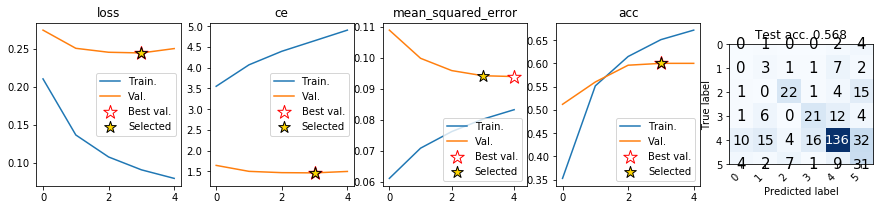

<Figure size 360x288 with 0 Axes>

/media/disk2/git/uob/RecyclingLabels/venv/lib/python3.6/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


q_0 weak = 0.841
q_0 true = 0.159
Epoch 3, val_loss = 2.44e-01, val_acc = 0.60 Restoring model weights from the end of the best epoch
Epoch 4, val_loss = 2.50e-01, val_acc = 0.60 Epoch 00005: early stopping


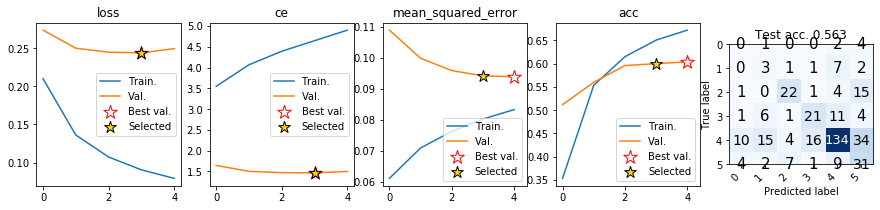

<Figure size 360x288 with 0 Axes>

/media/disk2/git/uob/RecyclingLabels/venv/lib/python3.6/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


q_0 weak = 0.841
q_0 true = 0.159
Epoch 9, val_loss = 2.35e-01, val_acc = 0.54 

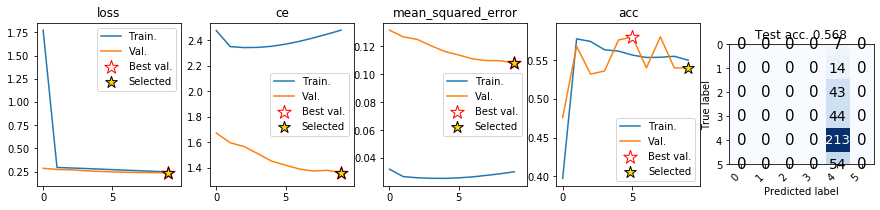

<Figure size 360x288 with 0 Axes>

Best l2 = 1e-06


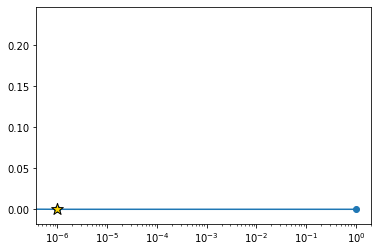

In [10]:
train_method = 'EM estimated M'
from wlc.WLweakener import estimate_M

models_list[train_method] = []
val_losses = numpy.zeros_like(l2_list)
for i, l2 in enumerate(l2_list):
    model = make_model(EM_log_loss, l2=l2)

    M_estimated_list = []
    n_samples_train = X_w_train.shape[0] + X_wt_train.shape[0]
    # Add weak samples
    for i in range(len(M_list)):
        M = estimate_M(Z_wt_train_list[i], Y_wt_train_list[i],
                       range(n_classes), reg='Partial', Z_reg=Z_w_train_list[i], alpha=1)
        q = (X_w_train_list[i].shape[0]/n_samples_train)
        M_estimated_list.append(M * q)
        print('q_{} weak = {:.3f}'.format(i, q))
    # Add true samples
    M_supervised = computeM(n_classes, method='supervised')
    for i in range(len(M_list)):
        q = (X_wt_train_list[i].shape[0]/n_samples_train)
        M_estimated_list.append(M_supervised * q)
        print('q_{} true = {:.3f}'.format(i, q))

    M_estimated = numpy.concatenate(M_estimated_list)
    last_index = 0
    Z_train_index_list = []
    V_train_list = []
    # Add weak samples
    for i in range(len(M_method_list)):
        Z_train_index_list.append(last_index + weak_to_index(Z_w_train_list[i], method='random_weak'))
        last_index += 2**n_classes
        V_train_list.append(M_estimated[Z_train_index_list[-1]])
    # Add true samples
    for i in range(len(M_method_list)):
        Z_train_index_list.append(last_index + weak_to_index(Y_wt_train_list[i], method='supervised'))
        last_index += n_classes
        V_train_list.append(M_estimated[Z_train_index_list[-1]])

    history = model.fit(numpy.concatenate((*X_w_train_list, *X_wt_train_list)),
                        numpy.concatenate(V_train_list),
                        **fit_kwargs)

    plot_history(history, model, X_wt_test, y_wt_test)
    models_list[train_method].append(model)
    best_epoch = numpy.argmin(model.history.history['val_loss'])
    val_losses[i] = model.history.history['val_loss'][best_epoch]
    plt.show()
    
best_l2 = numpy.argmin(val_losses)
final_models[train_method] = models_list[train_method][best_l2]
l2 = l2_list[best_l2]
print('Best l2 = {}'.format(l2))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogx(l2_list, val_losses, 'o-')
ax.scatter(l2, val_losses[best_l2], color='gold',
           edgecolor='black', marker='*', s=150, zorder=3)

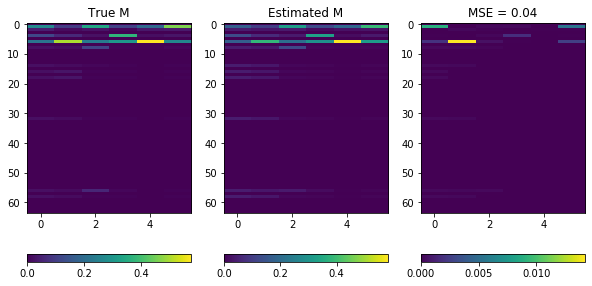

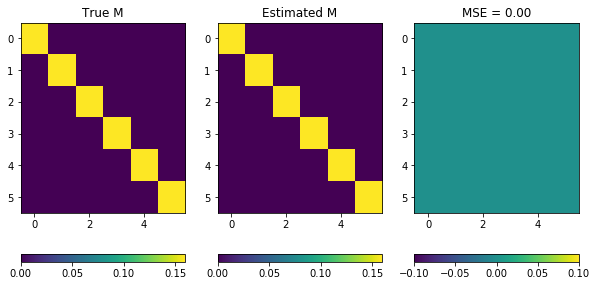

In [11]:
for i, (m1, m2) in enumerate(zip(M_true_list, M_estimated_list)):
    fig = plt.figure(figsize=(10, 5)) 
    ax = fig.add_subplot(1,3,1)
    ax.set_title('True M')
    cax = ax.imshow(m1, interpolation='nearest', aspect='auto')
    fig.colorbar(cax, orientation="horizontal")
    ax = fig.add_subplot(1,3,2)
    ax.set_title('Estimated M')
    cax = ax.imshow(m2, interpolation='nearest', aspect='auto')
    fig.colorbar(cax, orientation="horizontal")
    if m1.shape == m2.shape:
        mse = numpy.power(m1 - m2, 2).sum()
        ax = fig.add_subplot(1,3,3)
        ax.set_title('MSE = {:.2f}'.format(mse))
        cax = ax.imshow(numpy.power(m1 - m2, 2), interpolation='nearest', aspect='auto')
        fig.colorbar(cax, orientation="horizontal")

# Weak (lowerbound)

Epoch 0, val_loss = 2.84e-01, val_acc = 0.44 Restoring model weights from the end of the best epoch
Epoch 1, val_loss = 2.88e-01, val_acc = 0.40 Epoch 00002: early stopping


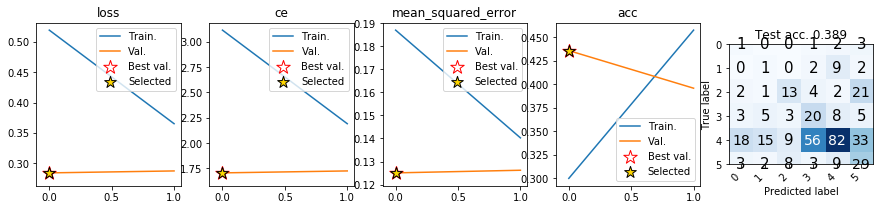

<Figure size 360x288 with 0 Axes>

Epoch 0, val_loss = 2.84e-01, val_acc = 0.44 Restoring model weights from the end of the best epoch
Epoch 1, val_loss = 2.88e-01, val_acc = 0.40 Epoch 00002: early stopping


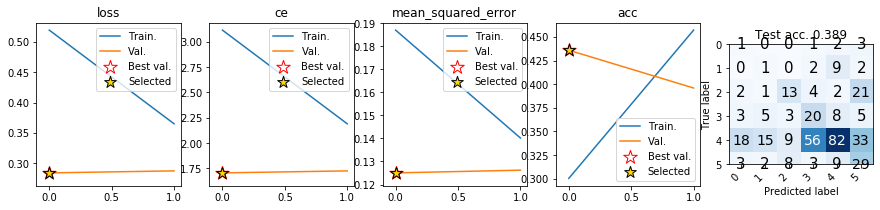

<Figure size 360x288 with 0 Axes>

Epoch 6, val_loss = 2.74e-01, val_acc = 0.46 Restoring model weights from the end of the best epoch
Epoch 7, val_loss = 2.76e-01, val_acc = 0.47 Epoch 00008: early stopping


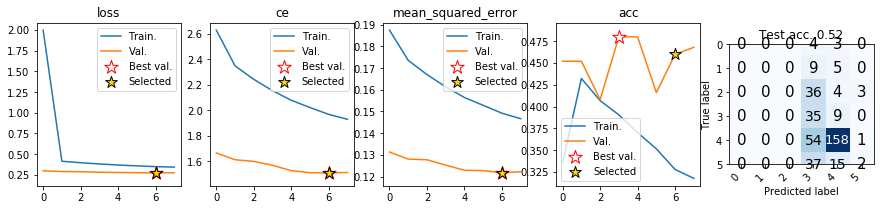

<Figure size 360x288 with 0 Axes>

Best l2 = 0.0


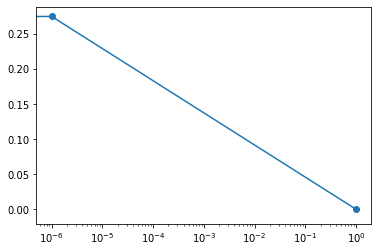

In [12]:
train_method = 'Weak'
from wlc.WLweakener import estimate_M

models_list[train_method] = []
val_losses = numpy.zeros_like(l2_list)
for l2 in l2_list:
    model = make_model(log_loss, l2=l2)

    history = model.fit(numpy.concatenate((*X_w_train_list, *X_wt_train_list)),
                        numpy.concatenate((*Z_w_train_list, *Y_wt_train_list)),
                        **fit_kwargs)

    plot_history(history, model, X_wt_test, y_wt_test)
    models_list[train_method].append(model)
    best_epoch = numpy.argmin(model.history.history['val_loss'])
    val_losses[i] = model.history.history['val_loss'][best_epoch]
    plt.show()
    
best_l2 = numpy.argmin(val_losses)
final_models[train_method] = models_list[train_method][best_l2]
l2 = l2_list[best_l2]
print('Best l2 = {}'.format(l2))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogx(l2_list, val_losses, 'o-')
ax.scatter(l2, val_losses[best_l2], color='gold',
           edgecolor='black', marker='*', s=150, zorder=3)

# Optimistic Superset Loss

Epoch 1, val_loss = 3.00e-01, val_acc = 0.46 Restoring model weights from the end of the best epoch
Epoch 2, val_loss = 3.02e-01, val_acc = 0.47 Epoch 00003: early stopping


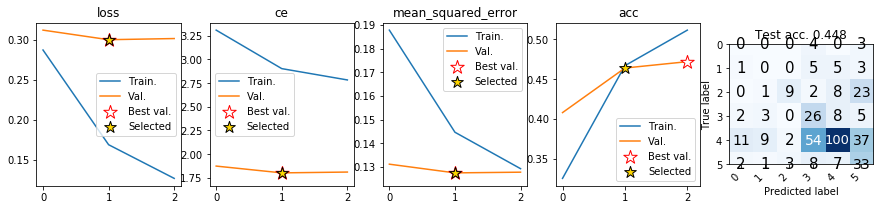

<Figure size 360x288 with 0 Axes>

Epoch 1, val_loss = 3.00e-01, val_acc = 0.46 Restoring model weights from the end of the best epoch
Epoch 2, val_loss = 3.02e-01, val_acc = 0.47 Epoch 00003: early stopping


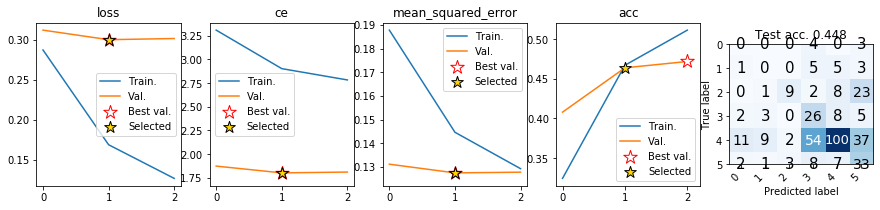

<Figure size 360x288 with 0 Axes>

Epoch 2, val_loss = 2.90e-01, val_acc = 0.34 Restoring model weights from the end of the best epoch
Epoch 3, val_loss = 2.91e-01, val_acc = 0.36 Epoch 00004: early stopping


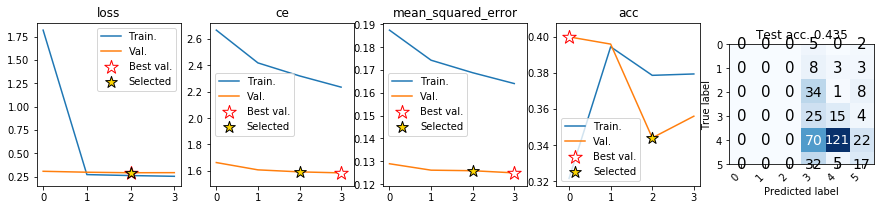

<Figure size 360x288 with 0 Axes>

Best l2 = 1.00e+00


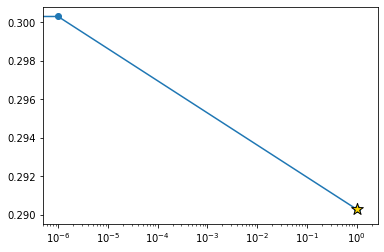

In [13]:
train_method = 'OSL'
def OSL_log_loss(y_true, y_pred):
    # Careful, I had to use a global variable here for the number of classes
    # for some reason I can not use y_osl.shape[-1] in the reshape function
    y_pred = K.clip(y_pred, K.epsilon(), 1.0-K.epsilon())
    y_osl = y_true * y_pred
    y_osl_max = K.max(y_osl, axis=-1)
    y_osl_max = K.repeat_elements(y_osl_max, n_classes, 0)
    y_osl_max = K.reshape(y_osl_max, (-1, n_classes))
    y_osl = K.cast(K.equal(y_osl, y_osl_max), y_pred.dtype)
    y_osl = y_osl / K.sum(y_osl, axis=-1, keepdims=True)
    out = -K.stop_gradient(y_osl) * K.log(y_pred)
    return K.mean(out, axis=-1)

models_list[train_method] = []
val_losses = numpy.zeros_like(l2_list)
for i, l2 in enumerate(l2_list):
    model = make_model(OSL_log_loss, l2=l2)

    history = model.fit(numpy.concatenate((*X_w_train_list, *X_wt_train_list)),
                        numpy.concatenate((*Z_w_train_list, *Y_wt_train_list)),
                        **fit_kwargs)

    plot_history(history, model, X_wt_test, y_wt_test)
    models_list[train_method].append(model)
    best_epoch = numpy.argmin(model.history.history['val_loss'])
    val_losses[i] = model.history.history['val_loss'][best_epoch]
    plt.show()
    
best_l2 = numpy.argmin(val_losses)
final_models[train_method] = models_list[train_method][best_l2]
l2 = l2_list[best_l2]
print('Best l2 = {:.2e}'.format(l2))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogx(l2_list, val_losses, 'o-')
ax.scatter(l2, val_losses[best_l2], color='gold',
           edgecolor='black', marker='*', s=150, zorder=3)

## Convex Loss for Partial Labels

- To implement from Cour et al. (2011) Learning from partial labels

def CLPL_log_loss(y_true, y_pred):
    # to implement
    return K.mean(out, axis=-1)

model = make_model(CLPL_log_loss, l2=l2)

history = model.fit(numpy.concatenate((*X_w_train_list, *X_wt_train_list)),
                    numpy.concatenate((*Z_w_train_list, *Y_wt_train_list)),
                    **fit_kwargs)
    
plot_history(history, model, X_test, y_test)

final_models['OSL'] = model

## Regularized Nearest Class Mean Forest classifiers

- To implement from Ristin et al. (2015) From categories to subcategories: Large-scale image classification with partial class label refinement

In [14]:
final_models

{'Supervised': <keras.engine.sequential.Sequential at 0x7f58b2f4c908>,
 'EM best estimation M': <keras.engine.sequential.Sequential at 0x7f58b80d29e8>,
 'EM estimated M': <keras.engine.sequential.Sequential at 0x7f58b18a5e48>,
 'Weak': <keras.engine.sequential.Sequential at 0x7f58b0e104e0>,
 'OSL': <keras.engine.sequential.Sequential at 0x7f58b1b2e0f0>}

EM best estimation M : 0.568
EM estimated M : 0.5626666666666666
OSL : 0.43466666666666665
Supervised : 0.48533333333333334
Weak : 0.3893333333333333


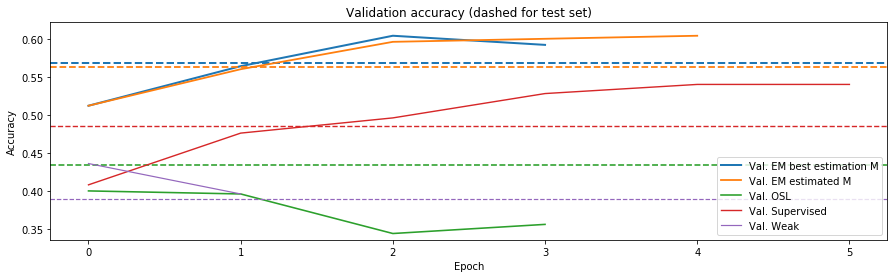

In [15]:
plt.figure(figsize=(15, 4))
lowest_acc = 1.0
highest_acc = 0.0
test_acc_dict = {}
for i, (key, model) in enumerate(sorted(final_models.items())):
    lw = (len(final_models)*2 - i)/5
    p = plt.plot(model.history.history['val_acc'], '-', lw=lw, label='Val. ' + key)
    test_acc = numpy.mean(model.predict_classes(X_wt_test) == y_wt_test)
    print('{} : {}'.format(key, test_acc))
    plt.axhline(y=test_acc, color=p[0].get_color(), lw=lw, linestyle='--')
    lowest_acc = test_acc if test_acc < lowest_acc else lowest_acc
    highest_acc = test_acc if test_acc > highest_acc else highest_acc
    test_acc_dict[key] = test_acc
plt.title('Validation accuracy (dashed for test set)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
range_acc = highest_acc - lowest_acc
plt.ylim([lowest_acc-range_acc*0.3, highest_acc+range_acc*0.3])
plt.legend()

# Save results and aggregate

- The following saves all the results of this experiment in a csv file
- And the next cell loads all the results with similar format and aggregates them in a final plot

In [16]:
export_dictionary = dict(
    dataset_name=dataset_name,
    random_state=random_state,
    train_prop=train_val_test_proportions[0],
    val_prop=train_val_test_proportions[1],
    test_prop=train_val_test_proportions[2],
    weak_prop=weak_prop,
    n_samples=n_samples,
    n_samples_train=n_samples_train,
    M_method_list='"' + ",".join(M_method_list) + '"',
    models='"' + ",".join(final_models.keys()) + '"',
    max_epochs=max_epochs,
)

import datetime

unique_file = '{}_{}_r{:03.0f}_{}'.format(experiment_name, dataset_name, random_state,
                                              datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S'))

export_dictionary = {**export_dictionary, **test_acc_dict}
csv_text ="\n".join([k+','+str(v) for k,v in export_dictionary.items()])
#You can store this CSV string variable to file as below
with open(unique_file + "_summary.csv", "w") as file:
    file.write(csv_text)

List of files to aggregate
['./Example_19_webs_r000_2019_08_20_13_22_35_summary.csv', './Example_19_webs_r000_2019_08_20_12_42_48_summary.csv']


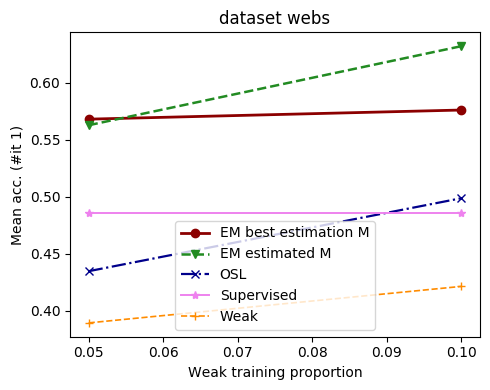

In [24]:
import os
import glob
import pandas

cmap = plt.cm.get_cmap('tab20')

from cycler import cycler
default_cycler = (cycler(color=['darkred', 'forestgreen', 'darkblue', 'violet', 'darkorange', 'saddlebrown']) +
                  cycler(linestyle=['-', '--', '-.', '-', '--', '-.']) + 
                  cycler(marker=['o', 'v', 'x', '*', '+', '.']) +
                  cycler(lw=[2, 1.8, 1.6, 1.4, 1.2, 1]))

plt.rcParams['figure.figsize'] = (3, 2)
plt.rcParams["figure.dpi"] = 100
plt.rc('lines', linewidth=1)
plt.rc('axes', prop_cycle=default_cycler)

files_list = glob.glob("./{}*summary.csv".format(experiment_name))
print('List of files to aggregate')
print(files_list)

list_ = []

for file_ in files_list:
    df = pandas.read_csv(file_,index_col=0, header=None, quotechar='"').T
    list_.append(df)

df = pandas.concat(list_, axis = 0, ignore_index = True)
df = df[df['dataset_name'] == dataset_name]
del df['dataset_name']
df_ = df

n_iterations = len(df_['random_state'].unique())
columns = df_['models'].iloc[0].split(',')
columns.append('weak_prop')
df_ = df_[columns]
df_ = df_.apply(pandas.to_numeric)
df_.index = df_['weak_prop']
del df_['weak_prop']
df_.sort_index(inplace=True)
df_ = df_.groupby(df_.index).mean()
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111)
for column in sorted(df_.columns):
    ax.plot(df_.index.values, df_[column], label=column)
ax.set_title('dataset {}'.format(dataset_name))
ax.set_ylabel('Mean acc. (#it {})'.format(n_iterations))
ax.set_xlabel('Weak training proportion')
ax.legend()
fig.tight_layout()
fig.savefig(os.path.join('{}_{}.svg'.format(experiment_name, dataset_name)))